In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyhsmm_mvpa as hsmm
from pyhsmm_mvpa import simulations
import seaborn as sns
import pandas as pd
import multiprocessing
from mne import channels

In [2]:
cpus = multiprocessing.cpu_count()
path = 'simulated/'
n_events = 25
sources = [['lateraloccipital-lh',1e-2, [np.random.gamma,2,25]],
           ['lateraloccipital-rh', 1e-2, [np.random.gamma, 2,75]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2, 80]],
           ['posteriorcingulate-rh', 1e-2, [np.random.gamma, 2,50]],
           ['postcentral-rh', 1e-2, [np.random.gamma, 2,100]],
           ['postcentral-lh', 1e-2, [np.random.gamma, 2,25]]]#Response trigger, amplitude scale make it hardly visible for hsmm

max_trial_length = 2000#ms

bump_frequency = 10.
file = 'dataset1'
mne_path = path+file+'_raw.fif'

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=True)

Aligning file name to MNE's convention
Simulating dataset1_raw.fif in simulated/
Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset1_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset1_raw.fif
[done]
simulated/dataset1_raw.fif simulated


In [3]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

resp_trigger = int(np.max(np.unique(generating_events[:,2])))

i,x = 1,0                  
while x <len(random_source_times):
    for j in np.arange(number_of_sources):
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
eeg_dat = hsmm.utils.read_mne_EEG([mne_path,], event_id, resp_id, raw.info['sfreq'],events)
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False,single=True, return_weights=True, n_comp=4)
hsmm_dat = hsmm.utils.stack_data(hsmm_dat,'',single=True)

Reading 0 ... 59999  =      0.000 ...    99.896 secs...
Adding metadata with 2 columns
25 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Using data from preloaded Raw for 25 events and 3124 original time points ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0.001 and 5 seconds


# Estimating a x bump model

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


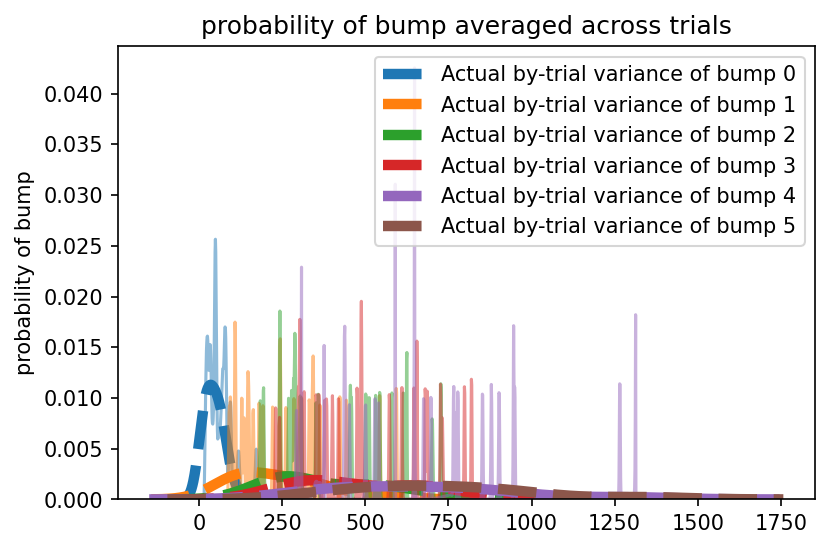

<xarray.DataArray 'parameters' (stage: 6)>
array([ 0.92141414, -0.91893527,  2.84466321, -3.6603729 ,  6.43613719,
       -5.62290637])
Dimensions without coordinates: stage


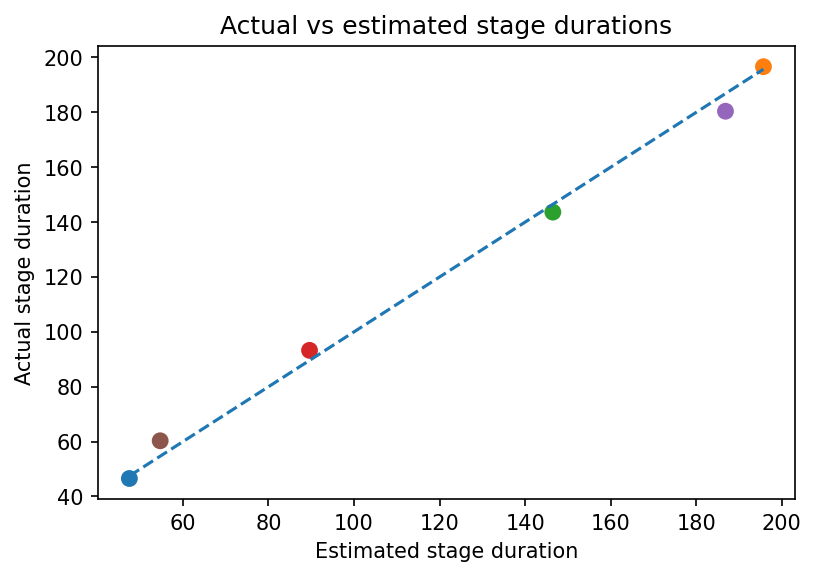

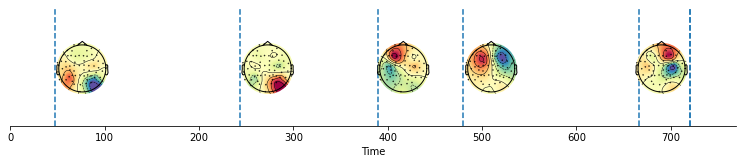

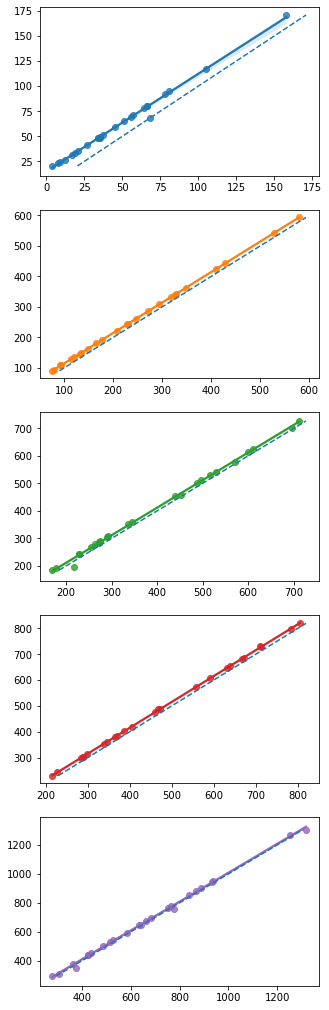

In [4]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=5)
estimates = init.fit_single(number_of_sources-1)

plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
for i in range(len(random_source_times.T)):
    if i <=estimates.eventprobs.mean(dim=['trial']).bump.max():
        plt.plot(estimates.eventprobs.mean(dim=['trial']).sel(bump=i), color=colors[i],alpha=.5);
    sns.kdeplot(np.sum(random_source_times[:,:i+1],axis=1),lw=5, color=colors[i]
                ,ls='--',label=f'Actual by-trial variance of bump {i}')
plt.legend()
plt.title('probability of bump averaged across trials')
plt.ylabel('probability of bump')
plt.show()
plt.figure(dpi=150)

print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(30,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(30,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, init.mean_bump_times(estimates.eventprobs), positions,#inferring electrode location, 
        bump_size=30, time_step = 1, magnify=1, figsize=(13,2),
        mean_rt = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

fig, ax= plt.subplots(5,1, figsize=(5,3*number_of_sources))
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1

## Iterative estimates

In [7]:
bests = init.backward_estimation(max_starting_points=2)
bests

Estimating all solutions for maximal number of bumps (10) with 1 random starting points
Estimating parameters for 10 bumps model
Parameters estimated for 10 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 10, stage: 11, params: 2, component: 4, bump: 10,
                  samples: 1338, trial: 25)
Coordinates:
  * n_bumps      (n_bumps) int64 10 9 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 833.7 1.022e+03 1.164e+03 ... 610.8 253.9
    parameters   (n_bumps, stage, params) float64 2.0 7.241 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.4458 -0.4987 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

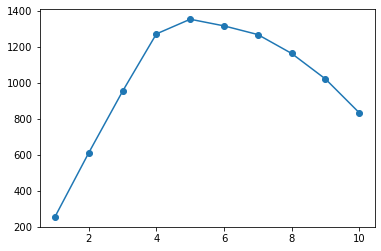

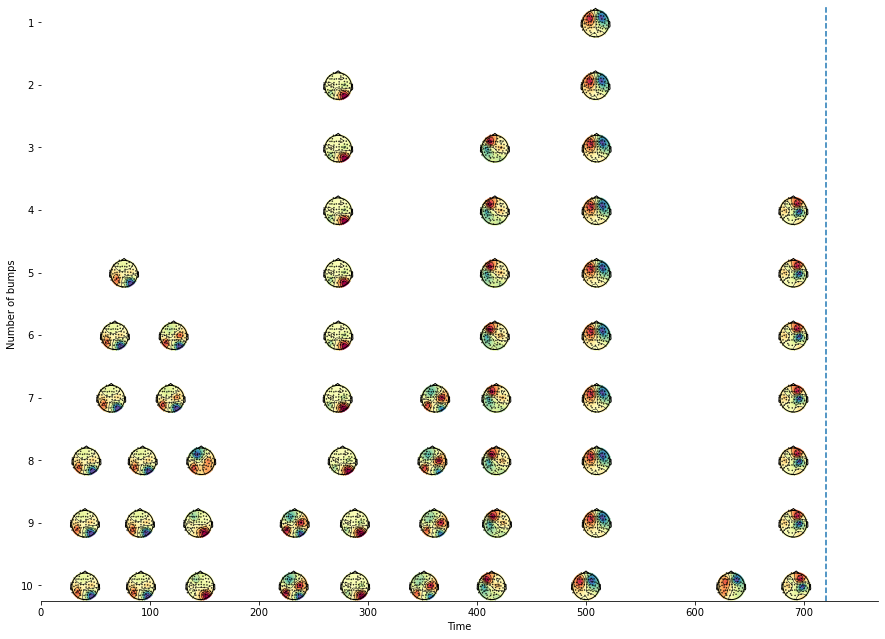

In [8]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.show()

electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs), positions,
    bump_size=30, time_step = 1, magnify=1, mean_rt = np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

In [ ]:
bests = init.backward_estimation(max_starting_points=10)
bests

Estimating all solutions for maximal number of bumps (10) with 9 random starting points
Estimating parameters for 10 bumps model


In [ ]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.show()

electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs), positions,
    bump_size=30, time_step = 1, magnify=1, mean_rt = np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})